# Picture book

Feed story lines and use generative AI to make the corresponding illustrations

In [1]:
import httpx
import base64
import io

from langchain.memory import ConversationBufferMemory, ConversationSummaryBufferMemory
from langchain import OpenAI, LLMChain, PromptTemplate

from PIL import Image, ImageDraw, ImageFont
from IPython.display import display

import textwrap

from ipywidgets import interact, interactive, fixed, interact_manual, interactive_output
import ipywidgets as widgets

In [2]:
fastchat_model = OpenAI(
    model="fastchat-t5-3b-v1.0",
    openai_api_base="http://localhost:8000/v1",
    openai_api_key="EMPTY"
)

In [13]:
def generate_image_desc(llm_chain, human_input):
    image_desc = llm_chain.predict(human_input=human_input)
    image_desc = image_desc.partition('Image: ')[2]
    return image_desc

def generate_image(human_input, image_input=None):
    post_req = {'prompt': f"children's cartoon: {human_input}"}
    if image_input:
        b = io.BytesIO()
        image_input.save(b, "JPEG")
        post_req["image"] = base64.b64encode(b.getbuffer()).decode('utf-8')
        
    r = httpx.post('http://localhost:8001/generate', json=post_req, timeout=60)
    image = Image.open(io.BytesIO(base64.b64decode(r.json()["image_bytes_base64"])))
    return image
    
def add_text(image, text, margin=40, offset=40, fill=(255, 255, 255)):
    im_draw = ImageDraw.Draw(image)
    for line in textwrap.wrap(text):
        im_draw.text((margin, offset), line, fill=fill)
        offset += 10
        
    
class StoryProcessor:
    
    def __init__(self, llm_chain):
        self.llm_chain = llm_chain
        self.images = []
        self.captions = []
        self.cap_images = []
        
    def update(self, caption):
        print(f"{caption=}")
        image_desc = generate_image_desc(self.llm_chain, caption)
        print(f"{image_desc=}")
        image = generate_image(image_desc, None)
        cap_image = image.copy()
        add_text(cap_image, caption, margin=40, offset=40)
        add_text(cap_image, image_desc, margin=40, offset=100)
        self.images.append(image)
        self.captions.append(caption)
        self.cap_images.append(cap_image)
    

In [16]:
class DemoApp:
    
    def __init__(self):
        self.reset()
        
    def reset(self):
        template = """
        You are a chatbot having a conversation with a human. 
        The human is reading a children's theme story to you one section at a time.
        Respond with a short image generation prompt describing a children's cartoon.
        Take into account previous responses.
        Respond in the format "Image: Coloring book style "

        {chat_history}
        Human: {human_input}
        Chatbot:"""

        prompt = PromptTemplate(
            input_variables=["chat_history", "human_input"], 
            template=template
        )
        memory = ConversationBufferMemory(memory_key="chat_history")
        llm_chain = LLMChain(
            llm=fastchat_model, 
            prompt=prompt, 
        #     verbose=True, 
            memory=memory,
        )

        self.sp = StoryProcessor(llm_chain=llm_chain)
        
        self.out = widgets.Output(layout={'border': '1px solid black', 'height': '480px', 'overflow': 'scroll'})
        self.out.clear_output()
        
    def save(self):
        self.sp.cap_images[0].save(
            "/tmp/book.pdf", "PDF" ,resolution=100.0, save_all=True, append_images=self.sp.cap_images[1:]
        )


In [5]:
app = DemoApp()
app.reset()

def process_caption(caption=''):
    if app.sp.captions and caption == app.sp.captions[-1]:
        return
    app.sp.update(caption)
    with app.out:
        display(app.sp.cap_images[-1])
    

process_caption_button = interactive(process_caption, {"manual": True, "manual_name": "Process Caption"})
display(process_caption_button, app.out)

interactive(children=(Text(value='', continuous_update=False, description='caption'), Button(description='Proc…

Output(layout=Layout(border_bottom='1px solid black', border_left='1px solid black', border_right='1px solid b…

In [ ]:
app.save()

In [6]:
one_fish_two_fish = """
One fish, Two fish, Red fish, Blue fish,
Black fish, Blue fish, Old fish, New fish.
---
This one has a little car.
This one has a little star.
Say! What a lot of fish there are.
---
Yes. Some are red, and some are blue.
Some are old and some are new.
---
Some are sad, and some are glad,
And some are very, very bad.
Why are they sad and glad and bad?
I do not know, go ask your dad.
---
Some are thin, and some are fat.
The fat one has a yellow hat.
---
From there to here,
From here to there,
Funny things are everywhere.
---
Here are some who like to run.
They run for fun in the hot, hot sun.
Oh me! Oh my! Oh me! oh my!
What a lot of funny things go by.
---
Some have two feet and some have four.
Some have six feet and some have more.
Where do they come from? I can't say.
But I bet they have come a long, long way.
---
we see them come, we see them go.
Some are fast. Some are slow.
Some are high. Some are low.
---
Not one of them is like another.
Don't ask us why, go ask your mother.
"""

robots = """
On the ground and in the air. Robots, robots, everywhere!
---
Up in space, beneath the seas, robots make discoveries!
"""

brown_bear = """
Brown bear, brown bear, what do you see?
I see a red bird looking at me.
---
Red bird, red bird, what do you see?
I see a yellow duck looking at me.
---
Yellow duck, yellow duck, what do you see?
I see a blue horse looking at me.
---
Blue horse, blue horse, what do you see?
I see a green frog looking at me.
---
Green frog, green frog, what do you see?
I see a purple cat looking at me.
"""

caption='\nBrown bear, brown bear, what do you see?\nI see a red bird looking at me.\n'
image_desc='Coloring book style of Brown Bear looking at a red bird in the forest.\n'


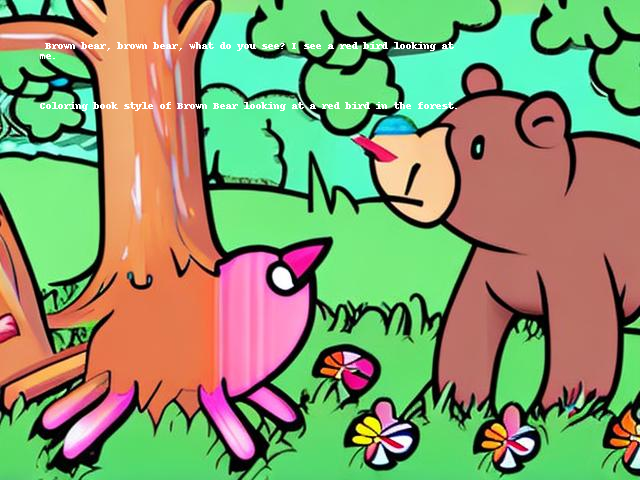

caption='\nRed bird, red bird, what do you see?\nI see a yellow duck looking at me.\n'
image_desc='Coloring book style of red bird and yellow duck together in the forest.\n'


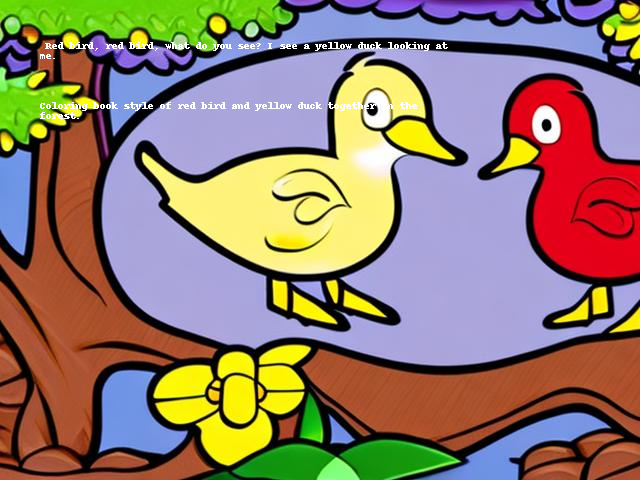

caption='\nYellow duck, yellow duck, what do you see?\nI see a blue horse looking at me.\n'
image_desc='Coloring book style of yellow duck looking at a blue horse in the forest.\n'


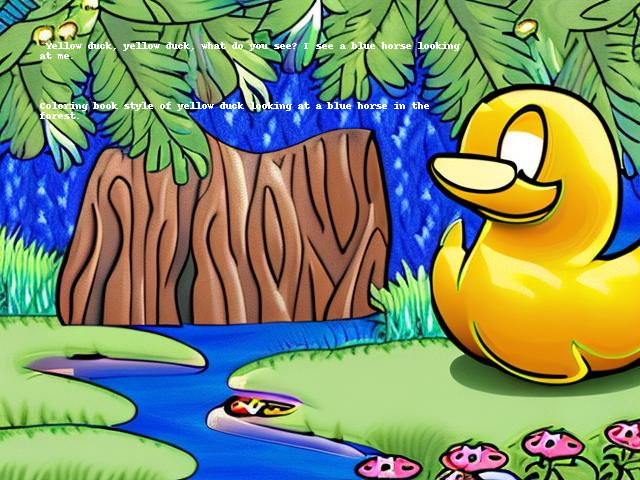

caption='\nBlue horse, blue horse, what do you see?\nI see a green frog looking at me.\n'
image_desc='Coloring book style of blue horse and green frog together in the forest.\n'


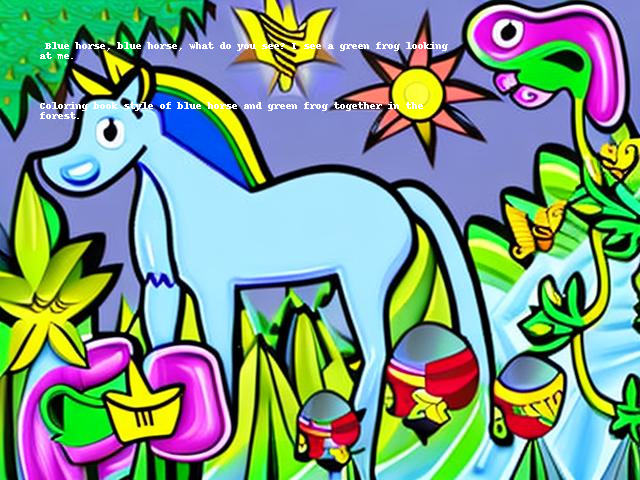

caption='\nGreen frog, green frog, what do you see?\nI see a purple cat looking at me.\n'
image_desc='Coloring book style of green frog looking at a purple cat in the forest.\n'


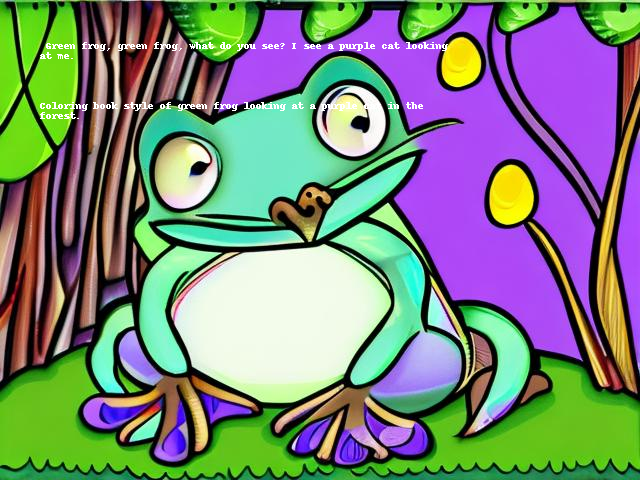

In [17]:
app = DemoApp()
app.reset()
for verse in brown_bear.split("---"):
    app.sp.update(verse)
    display(app.sp.cap_images[-1])
app.save()